<a href="https://colab.research.google.com/github/Haobo-Yang/Project1/blob/main/Project1finalversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How can frog grow its tail back?


In [ ]:
!pip install anndata
!pip install 'scanpy[leiden]'
!pip install louvain
!pip install gseapy


In this starter we provide some built-in functions for PCA and subsequent Leiden Clustering. We do not reqruire you write down PCA in this task, but for more details as to how you should use it, `scanpy` uses the `sklearn` PCA routine - for `R` users, there might be some usage discrepancies. Scaling/centering data is not automatically done and can be a careful choice here. For additional information on single cell specific use, you can consult this [tutorial](https://training.galaxyproject.org/training-material/topics/single-cell/tutorials/scrna-scanpy-pbmc3k/tutorial.html#dimensionality-reduction).


For the project, ask yourself some questions: why do we do PCA? how does this affect our data? how does the scaling affect? should we scale? what is the impact of the processing steps? does the interpretation carry over from classical ML use? How does the two formulations of PCA help you understand what is going on here?

## Processing the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import scanpy as sc
extract_dir = "/content/drive/MyDrive/" # use your own directory
adata = sc.read_h5ad(extract_dir+'Copy of cleaned_processed_frogtail.h5ad') # file path

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
adata

AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'

We need to select a timepoint. Let's plot them out first.

<Axes: xlabel='DaysPostAmputation', ylabel='Count'>

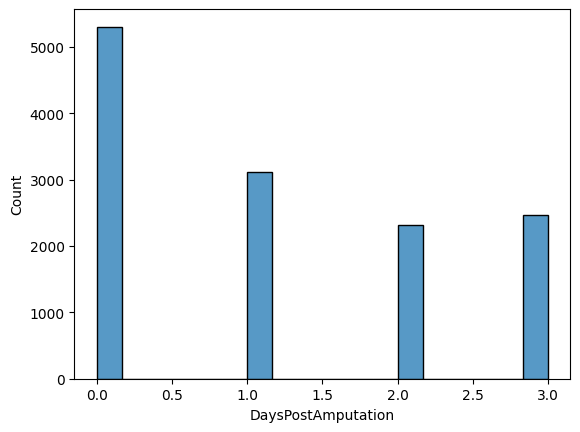

In [ ]:
import seaborn as sns
sns.histplot(adata.obs['DaysPostAmputation'])

Selecting timepoint 0 (Day of amputation).

In [ ]:
adata = adata[adata.obs['DaysPostAmputation'] == 0] # Subset on the time point 0
adata.layers['counts'] = adata.X.copy() # Copy the raw counts in a different layer

import numpy as np


<ipython-input-79-e1d5a84d0840>:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy() # Copy the raw counts in a different layer


In [ ]:
adata

AnnData object with n_obs × n_vars = 5302 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'
    layers: 'counts'

## PCA whitening for Leiden clustering



In [ ]:
sc.pp.filter_genes(adata, min_cells=5)

In [ ]:
adata

AnnData object with n_obs × n_vars = 5302 × 23111
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'
    var: 'n_cells'
    layers: 'counts'

### PCA on 2000 HVG

In [ ]:
#Scaling data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat', subset=True)


In [ ]:
#PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
# Whitening step - create neighbors graph based on PCA
sc.pp.neighbors(hvg_adata, n_pcs=7) # Create neighbors graph - n_pcs takes the number of principal components from PCA you keep for this step
sc.tl.leiden(hvg_adata, resolution=0.5)  # Apply Leiden clustering, you can adjust the resolution parameter


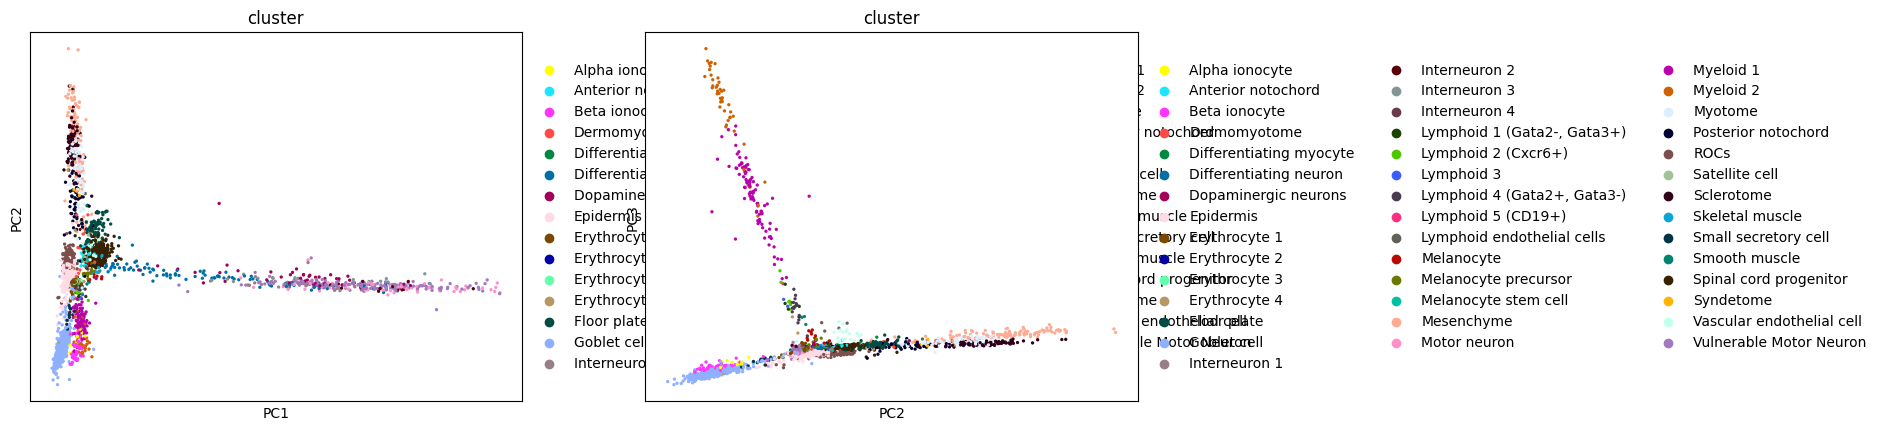

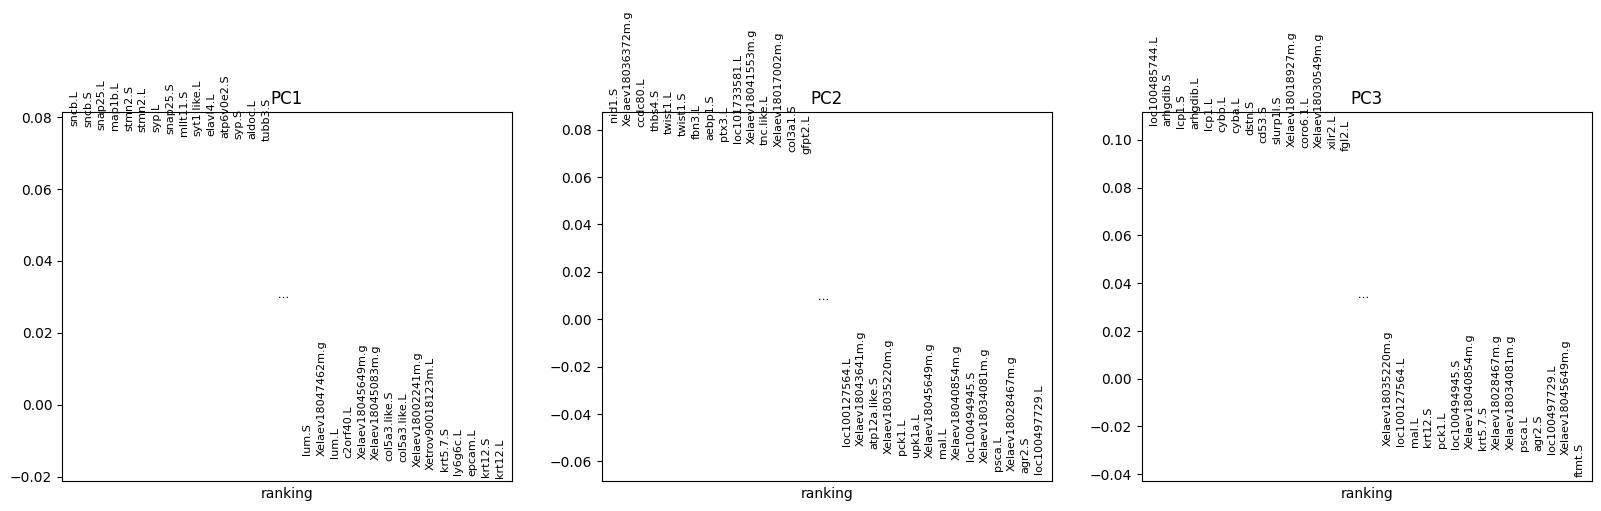

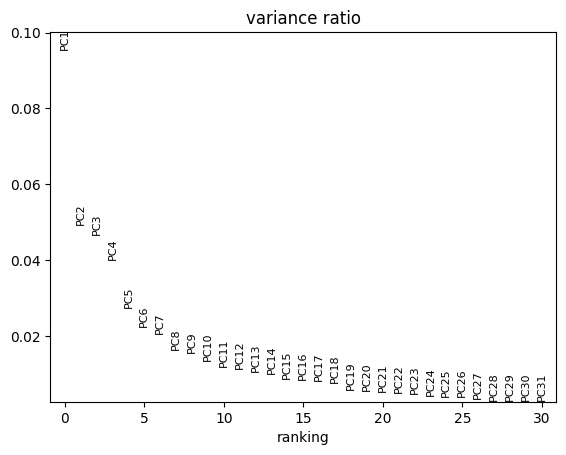

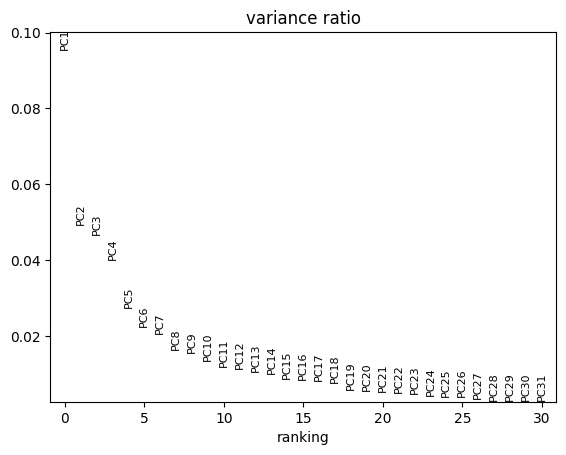

In [ ]:
sc.pl.pca_overview(adata, color='cluster', components= ['1,2', '2,3']) # Plot all diagnostics including PC1 against PC2 and PC2 against PC3
sc.pl.pca_variance_ratio(adata, log=False) # Plot the variance ratio


### PCA on 100 HVG

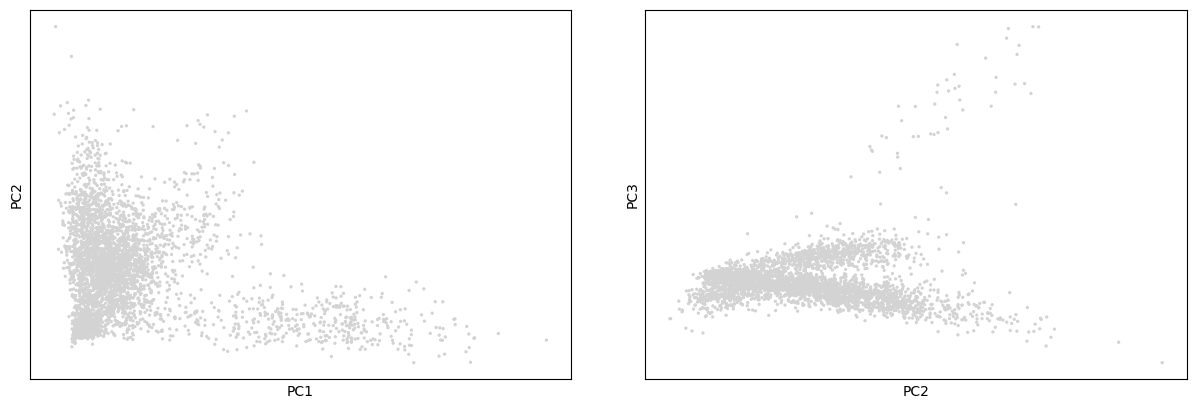

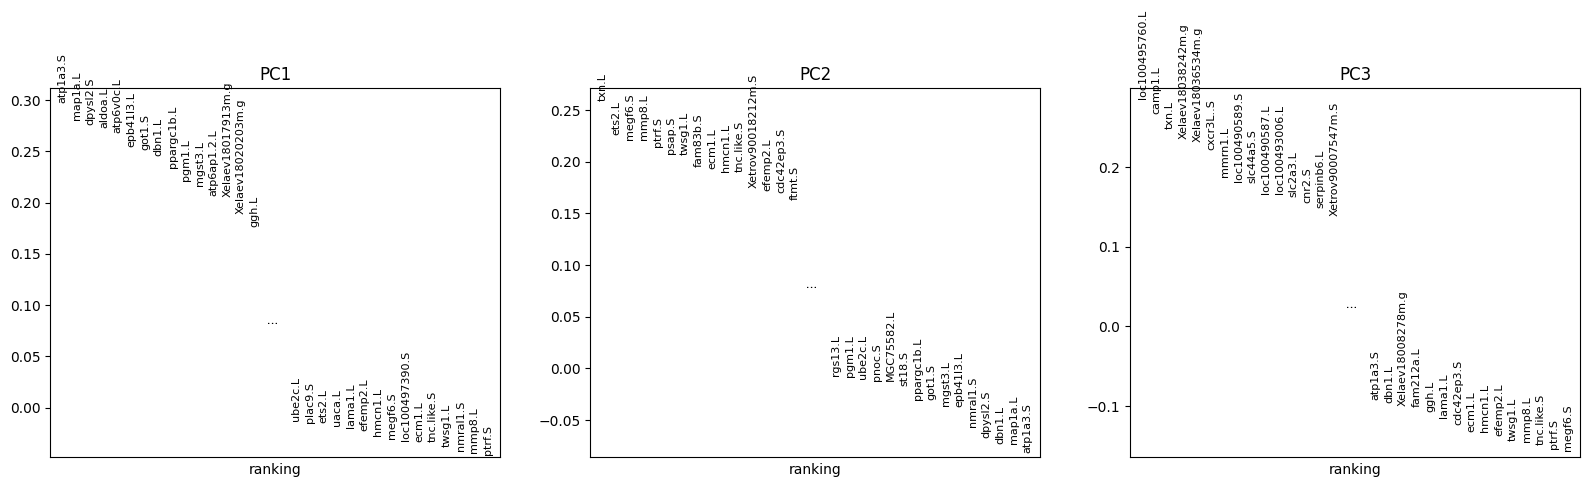

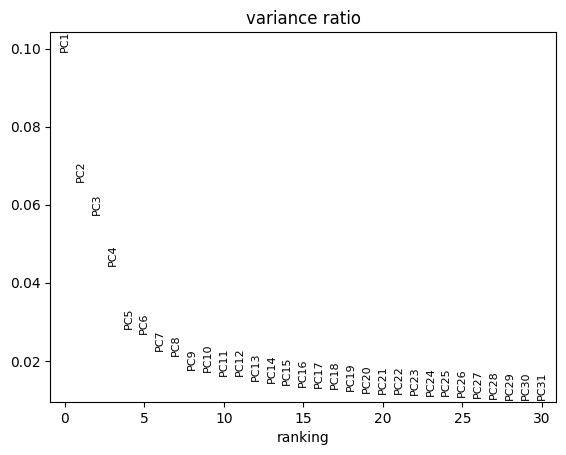

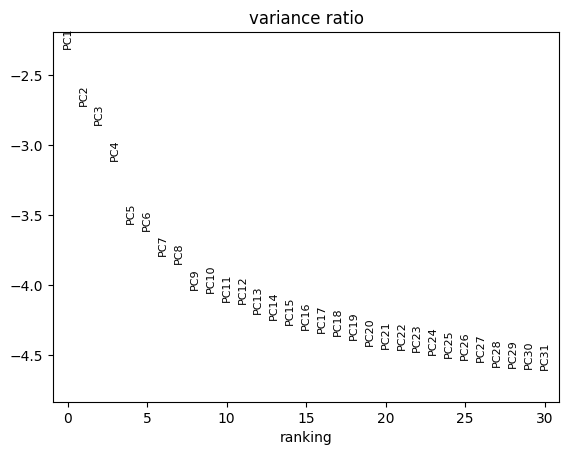

In [ ]:
#extract hvg
sc.pp.highly_variable_genes(adata, n_top_genes=100, flavor='seurat', subset=True)
hvg_adata = adata[:, adata.var['highly_variable']].copy()
sc.pp.scale(hvg_adata, max_value=10)
sc.tl.pca(hvg_adata, svd_solver='arpack')
sc.pl.pca_overview(hvg_adata, components= ['1,2', '2,3']) # Plot all diagnostics including PC1 against PC2 and PC2 against PC3
sc.pl.pca_variance_ratio(hvg_adata, log=True) # Plot the variance ratio

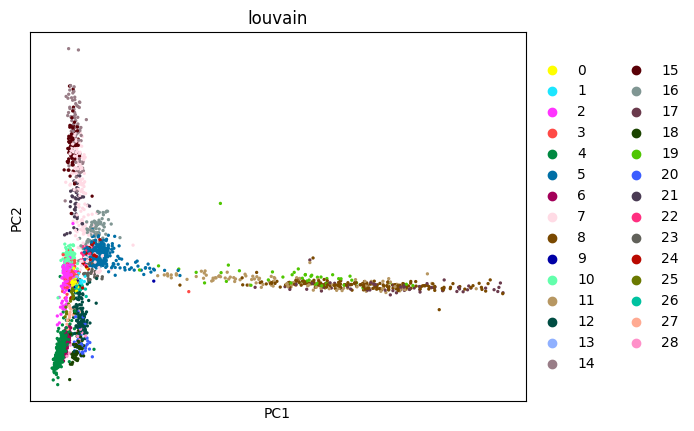

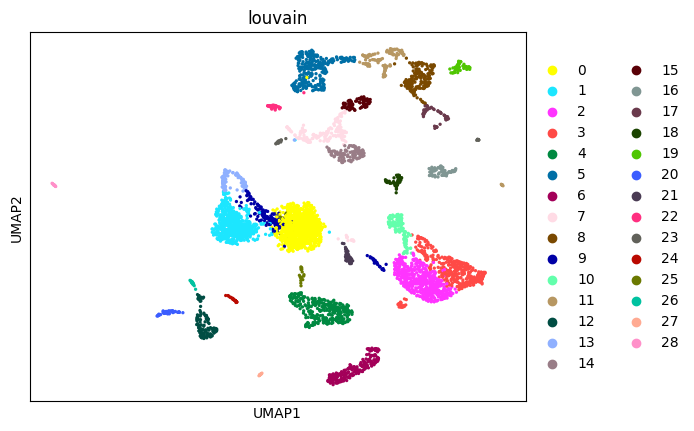

In [ ]:
# Compute the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
# operate Louvain
sc.tl.louvain(adata, resolution=1.0)
sc.tl.umap(adata)
sc.pl.pca(adata, color=['louvain'], save='_louvain_pca.png')
sc.pl.umap(adata, color=['louvain'], save='_louvain_umap.png')

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [ ]:
adata

AnnData object with n_obs × n_vars = 5302 × 100
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch', 'louvain'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'cluster_colors', 'neighbors', 'louvain', 'umap', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

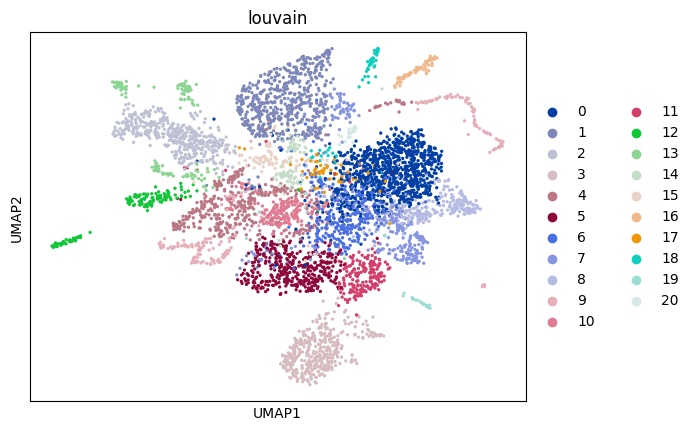

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat', subset=True)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

# Compute the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40)

# Run Louvain clustering
sc.tl.louvain(adata, resolution=1.0)  # Adjust resolution as needed
sc.tl.umap(adata)

# Visualize Louvain clusters
sc.pl.umap(adata, color=['louvain'], save='_louvain.png')

In [ ]:
hvg_adata.obs.head()

,barcode_cells,cell,sample,DevelopmentalStage,DaysPostAmputation,cluster,X,Y,CellCyclePhase,Sample,Lane,Condition,batch
1604,AAACCTGGTAATTGGA.1,AAACCTGGTAATTGGA.1,SIGAA5,st40,0,Differentiating neuron,10.943213,-1.818803,G1,SIGAA5,SLX-15583,ST40_0,3
1605,AAACCTGTCGCTTGTC.1,AAACCTGTCGCTTGTC.1,SIGAA5,st40,0,Erythrocyte 1,-4.683115,2.029120,G1,SIGAA5,SLX-15583,ST40_0,3
1606,AAACGGGAGGTGTTAA.1,AAACGGGAGGTGTTAA.1,SIGAA5,st40,0,Erythrocyte 3,-8.668563,4.375178,G1,SIGAA5,SLX-15583,ST40_0,3
1607,AAACGGGTCCCTGACT.1,AAACGGGTCCCTGACT.1,SIGAA5,st40,0,Differentiating neuron,9.162257,-2.653667,G2M,SIGAA5,SLX-15583,ST40_0,3
1608,AAAGATGAGTTATCGC.1,AAAGATGAGTTATCGC.1,SIGAA5,st40,0,Erythrocyte 3,-8.441736,5.272697,G1,SIGAA5,SLX-15583,ST40_0,3


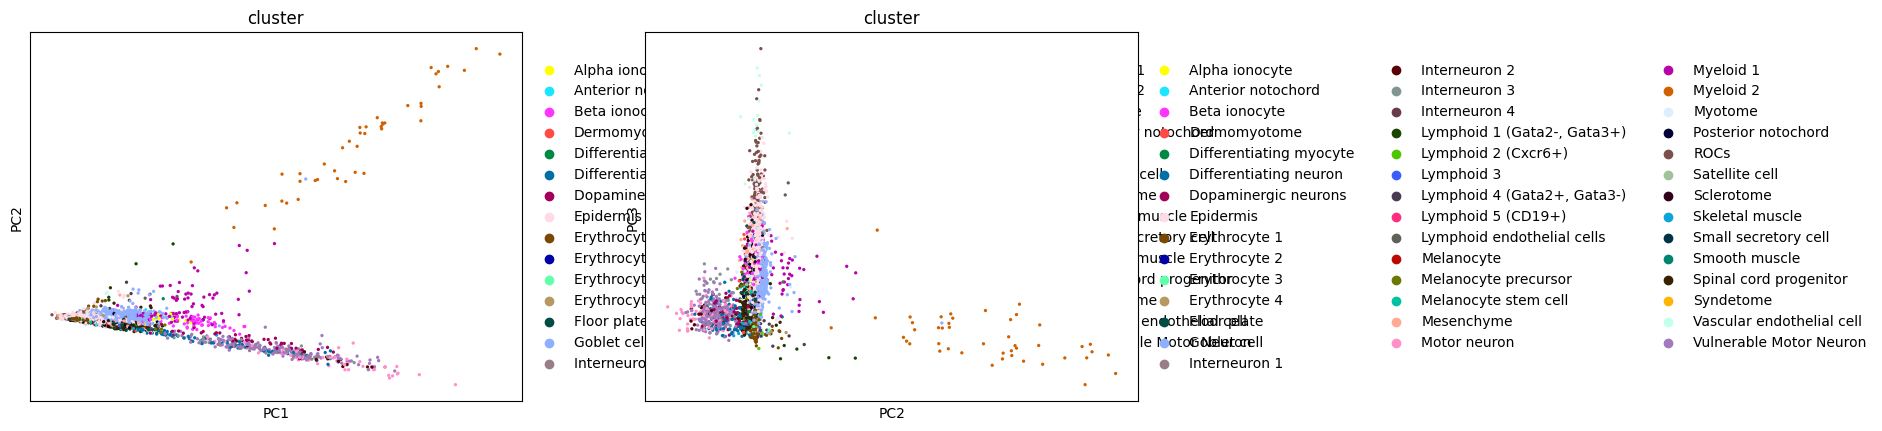

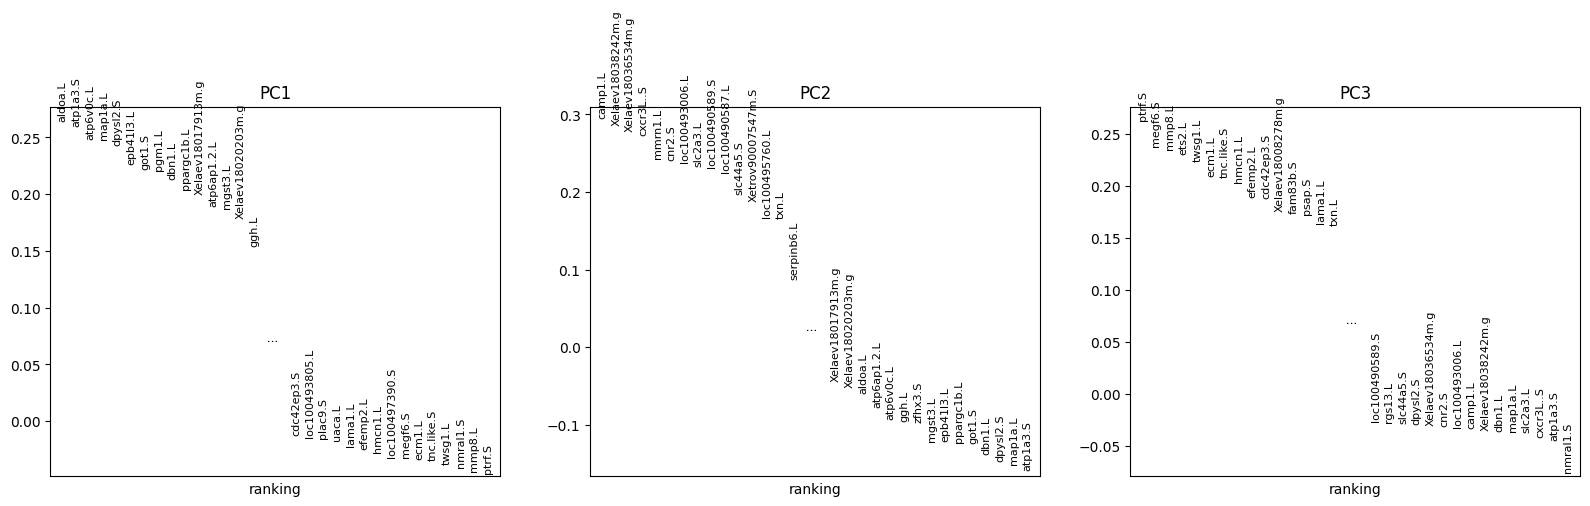

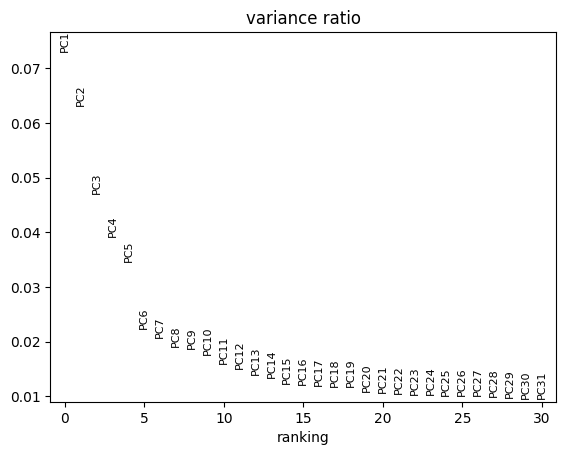

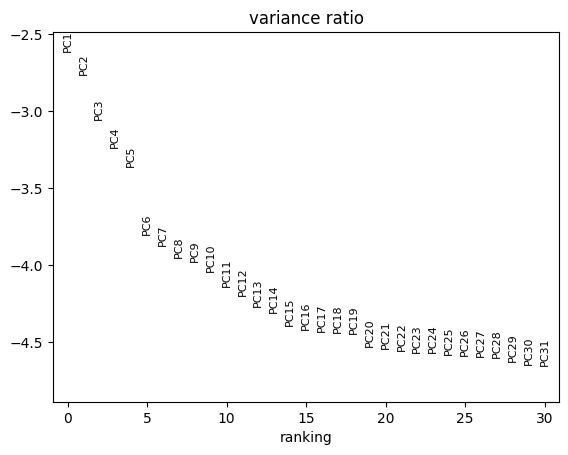

In [ ]:
import scanpy as sc
sc.pp.scale(hvg_adata) # Scale data
# Do PCA on the highly variable genes data
sc.tl.pca(hvg_adata)
sc.pp.pca(hvg_adata)

sc.pl.pca_overview(hvg_adata, color='cluster', components= ['1,2', '2,3']) # Plot all diagnostics including PC1 against PC2 and PC2 against PC3
sc.pl.pca_variance_ratio(hvg_adata, log=True) # Plot the variance ratio

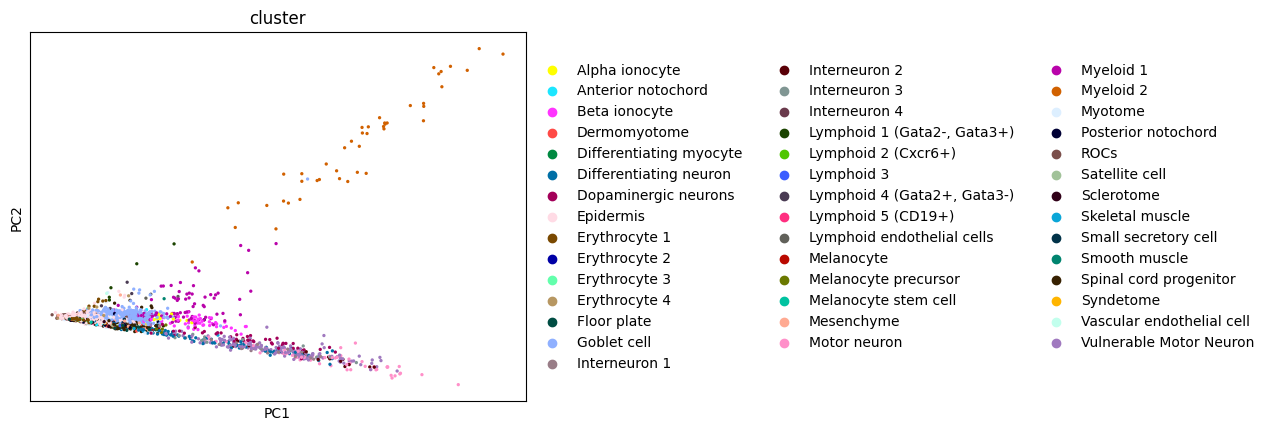

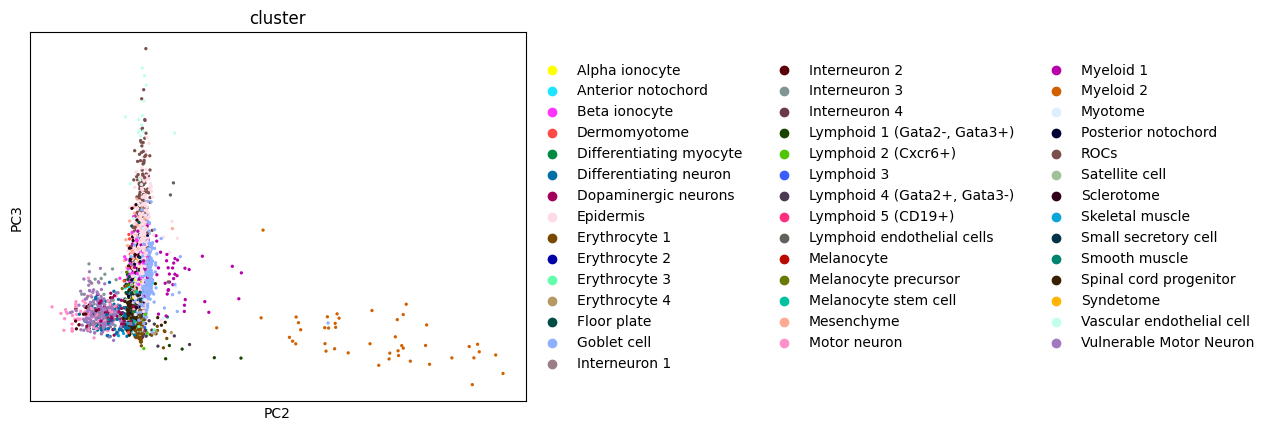

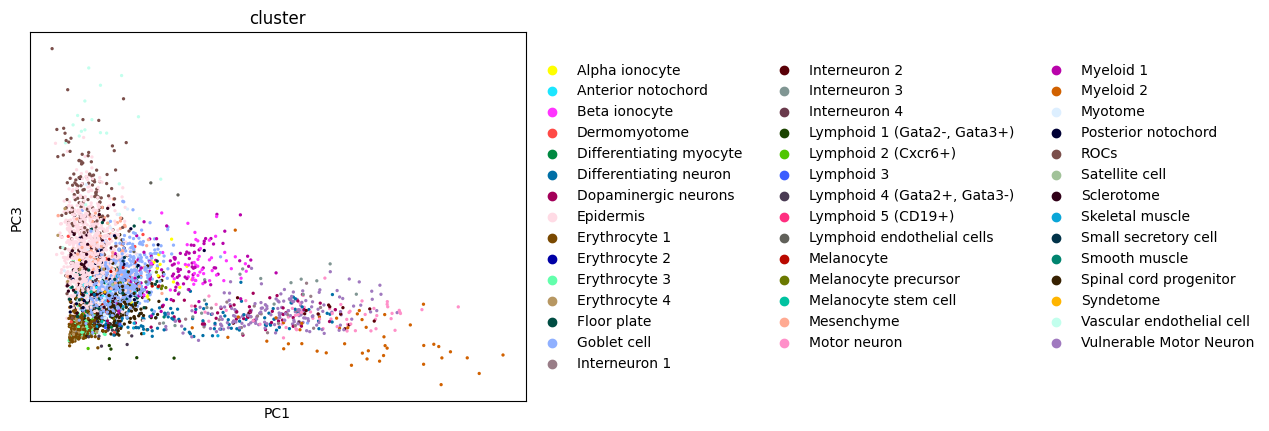

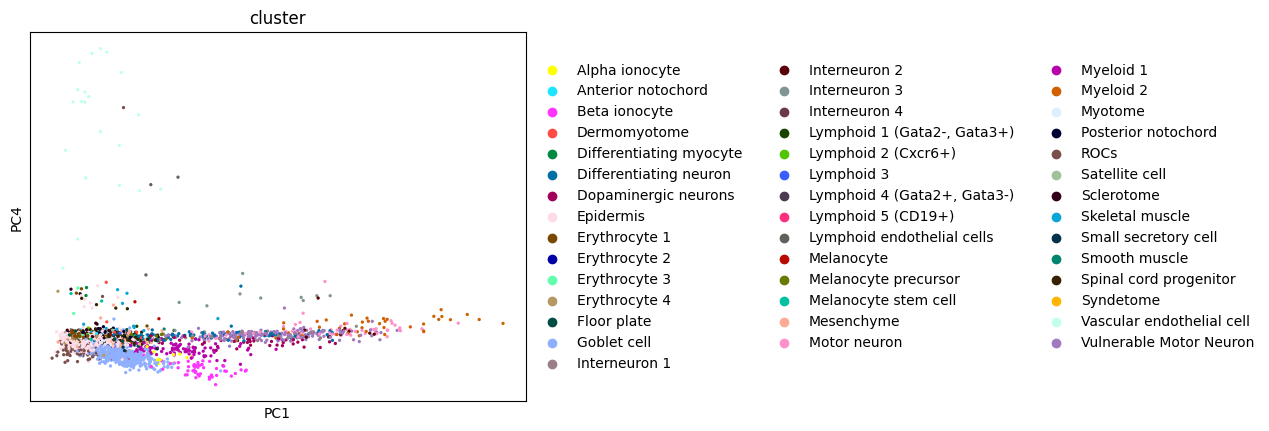

In [ ]:
sc.pl.pca(hvg_adata, color='cluster', components=['1, 2'])
sc.pl.pca(hvg_adata, color='cluster', components=['2, 3'])
sc.pl.pca(hvg_adata, color='cluster', components=['1, 3'])
sc.pl.pca(hvg_adata, color='cluster', components=['1, 4'])

## Leiden, t-SNE, ROC, and GO

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:461: 

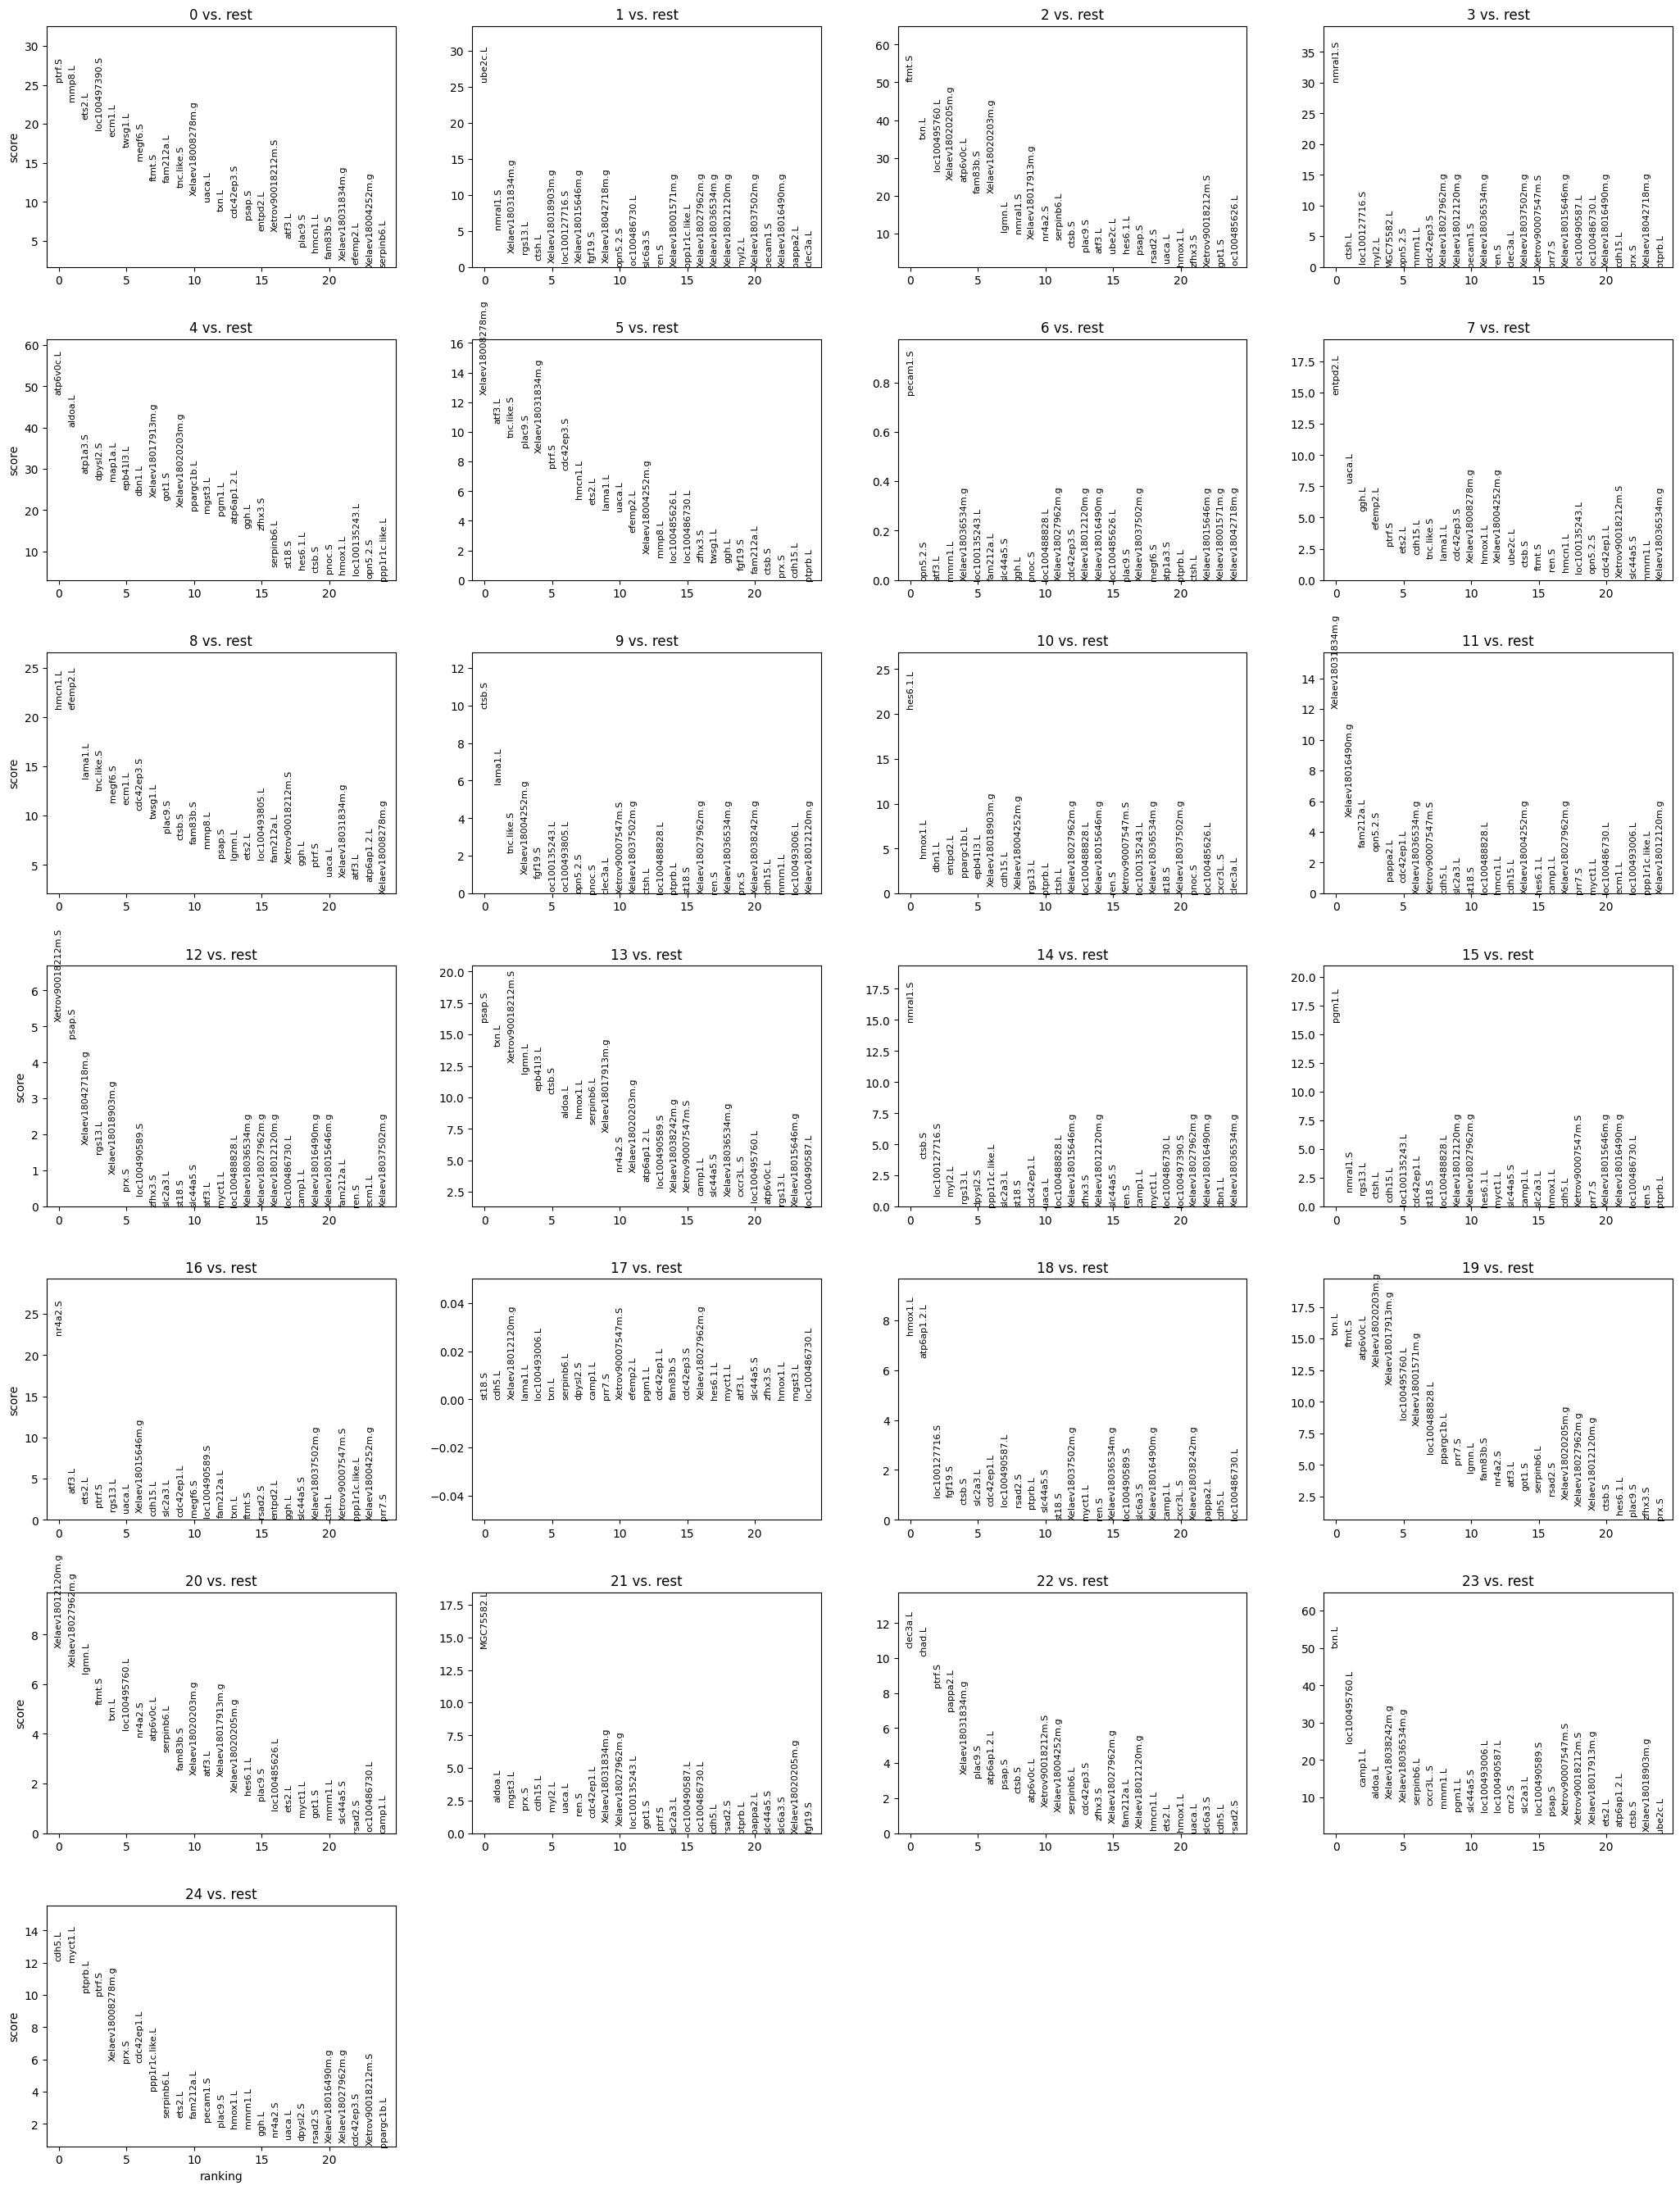

['ptrf.S' 'mmp8.L' 'ets2.L' 'loc100497390.S' 'ecm1.L' 'twsg1.L' 'megf6.S'
 'ftmt.S' 'fam212a.L' 'tnc.like.S' 'Xelaev18008278m.g' 'uaca.L' 'txn.L'
 'cdc42ep3.S' 'psap.S' 'entpd2.L' 'Xetrov90018212m.S' 'atf3.L' 'plac9.S'
 'hmcn1.L' 'fam83b.S' 'Xelaev18031834m.g' 'efemp2.L' 'Xelaev18004252m.g'
 'serpinb6.L' 'aldoa.L' 'ctsb.S' 'loc100486730.L' 'ggh.L' 'mgst3.L'
 'rsad2.S' 'loc100127716.S' 'Xelaev18015646m.g' 'ren.S'
 'Xelaev18037502m.g' 'pecam1.S' 'loc100490589.S' 'Xelaev18027962m.g'
 'rgs13.L' 'cdh5.L' 'prr7.S' 'loc100490587.L' 'opn5.2.S' 'chad.L'
 'slc6a3.S' 'slc2a3.L' 'loc100135243.L' 'Xelaev18036534m.g' 'myl2.L'
 'Xelaev18038242m.g' 'ctsh.L' 'myct1.L' 'Xelaev18020205m.g'
 'loc100493805.L' 'cdc42ep1.L' 'cdh15.L' 'Xetrov90007547m.S'
 'Xelaev18018903m.g' 'loc100485626.L' 'fgf19.S' 'Xelaev18042718m.g'
 'loc100488828.L' 'slc44a5.S' 'Xelaev18016490m.g' 'hmox1.L'
 'Xelaev18012120m.g' 'lgmn.L' 'clec3a.L' 'nr4a2.S' 'zfhx3.S' 'pappa2.L'
 'lama1.L' 'atp6ap1.2.L' 'cnr2.S' 'pnoc.S' 'ppp1r1c.like.L'

In [ ]:
# Compute the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Run Louvain clustering
sc.tl.louvain(adata, resolution=1.0)

# Identify marker genes for each cluster
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')

# View the top markers for each cluster
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# Extract markers for a specific cluster (e.g., cluster 0)
cluster_0_markers = adata.uns['rank_genes_groups']['names']['0']
print(cluster_0_markers)
print(adata.uns['rank_genes_groups'].keys())

# Compare with Supplementary Table 3
supplementary_table_3 = ['G2M', 'S', 'G1']

# Find unique markers for ROC
roc_markers = set(cluster_0_markers) - set(supplementary_table_3)

# Check if roc_markers is empty and provide a message
if not roc_markers:
    print("No ROC-specific markers found.")
else:
    print("ROC-specific markers:", roc_markers)
    roc_markers = [gene.upper() for gene in roc_markers]
    # Gene Ontology (GO) analysis
    import gseapy as gp

    try:
        enr = gp.enrichr(gene_list=list(roc_markers),
                        gene_sets='GO_Biological_Process_2021',
                        organism='Human',
                        outdir=None)
        enr.res2d.head(10)
    except:
        print("An error occurred.")


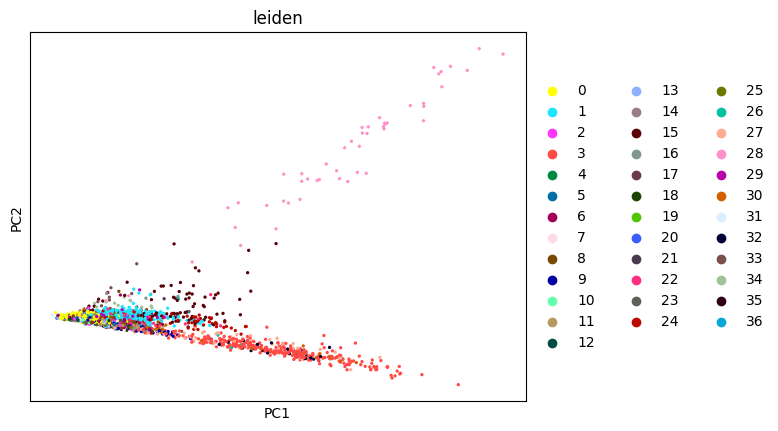

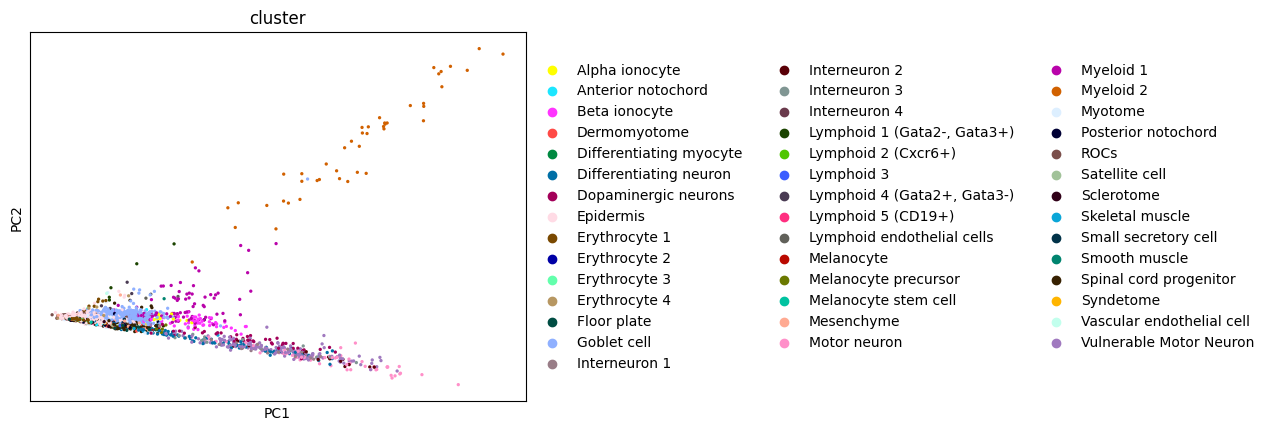

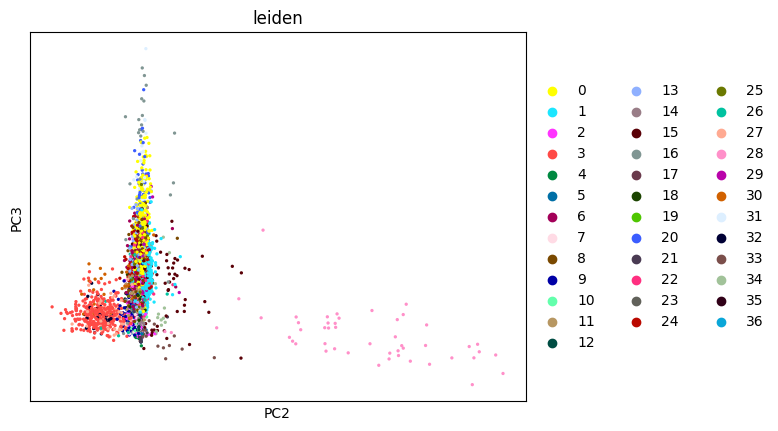

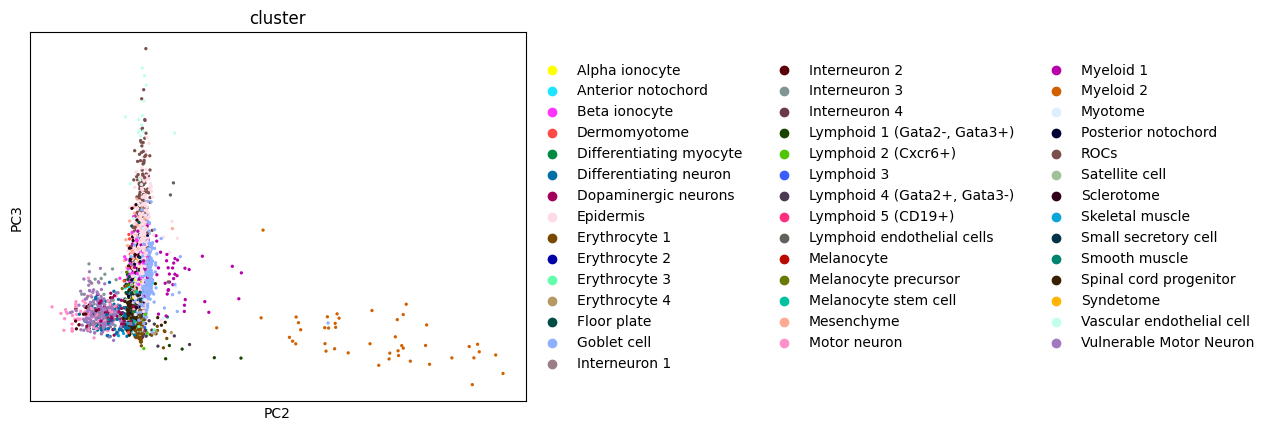

In [ ]:
sc.pp.neighbors(hvg_adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(hvg_adata)
sc.pl.pca(hvg_adata, color=['leiden']) # Plotting PC1/PC2 with colors from Leiden labels
sc.pl.pca(hvg_adata, color=['cluster']) # Plotting PC1/PC2 with colors from original paper cluster
sc.pl.pca(hvg_adata, color=['leiden'], components='2,3')
sc.pl.pca(hvg_adata, color=['cluster'], components='2,3')

['ptrf.S']


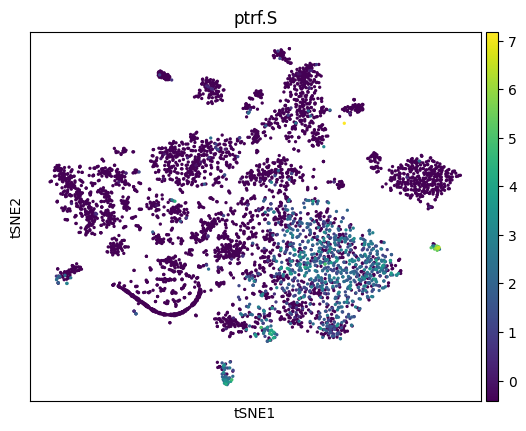

In [ ]:
# Run t-SNE
sc.tl.tsne(adata, n_pcs=40, perplexity=30)  # Adjust perplexity as needed
# extract marker genes from cluster 0
cluster_0_markers = adata.uns['rank_genes_groups']['names']['0'][:1]  # top1 genes
print(cluster_0_markers)

# marker to print t-SNE
sc.pl.tsne(adata, color=cluster_0_markers, save='_tsne_markers.png')

In [ ]:
from sklearn.metrics import rand_score, adjusted_rand_score, silhouette_score, v_measure_score

# cluster labels in `adata.obs['louvain']`
labels = adata.obs['louvain']

ri = rand_score(ground_truth_labels, labels)
print(f"Rand Index (RI): {ri}")

# Silhouette Score
silhouette_avg = silhouette_score(adata.obsm['X_pca'], labels)
print(f"Silhouette Score: {silhouette_avg}")

# Adjusted Rand Index (ARI)
ground_truth_labels = adata.obs['cluster']
ari = adjusted_rand_score(ground_truth_labels, labels)
print(f"Adjusted Rand Index (ARI): {ari}")

# V-Measure
v_measure = v_measure_score(ground_truth_labels, labels)
print(f"V-Measure: {v_measure}")

Rand Index (RI): 0.8815606060250264
Silhouette Score: -0.14638523757457733
Adjusted Rand Index (ARI): 0.27068354576913595
V-Measure: 0.4464120295718808
